In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 721 kB 4.8 MB/s 


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 79.9 MB/s 


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" 
import os
import shutil
import tempfile
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

### training and validation dataset
#path_train_volumes
###### create nnunet monaie for multiclass 3D segmentation problem
import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    Spacingd,
    Orientationd,
    SpatialPadd,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    CastToTyped,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandFlipd,
    ToTensord,
    Resized,RandShiftIntensityd,SpatialPadd
)
from monai.utils import first

### tranform the images
import os
from glob import glob
import shutil
from tqdm import tqdm
#import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
set_determinism(seed=0)
import os
import nibabel as nib
import glob as glob

In [ ]:
#dwi_path = os.path.join(isles_data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
  #                  'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))

In [ ]:
data_dir='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
#example_case=1
#dwi_path = os.path.join(data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                #    'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))
#print(dwi_path)
path_train_volumes = sorted(glob.glob(os.path.join(data_dir, "rawdata","*","*","*_dwi.nii.gz")))
#path_train_volumes
#path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "derivatives",'*',"*.nii.gz")))
path_train_segmentation = sorted(glob.glob(os.path.join(data_dir, "derivatives","*","*","*.nii.gz")))

In [ ]:
#path_train_volumes[0]

'/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_dwi.nii.gz'

In [ ]:
from monai.data import (
    Dataset,
    DatasetSummary,
    load_decathlon_datalist,
    load_decathlon_properties,
)
train_files=[{'image':image_name,'label':label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
dataset = Dataset(data=train_files,transform=LoadImaged(keys=["image", "label"]),)

#LoadImaged(keys=["vol", "seg"])
#train_ds = Dataset(data=train_files)
#data_loader = DataLoader(dataset=train_ds, batch_size=1, num_workers=0)

#train_loader = DataLoader(train_ds, batch_size=1)
calculator = DatasetSummary(dataset)
target_spacing = calculator.get_target_spacing()
print("spacing: ", target_spacing)
#this function also prints the mean and std values (used for normalization), 
calculator.calculate_statistics()
print("mean: ", calculator.data_mean, " std: ", calculator.data_std)
#the min (0.5 percentile) and max(99.5 percentile) values (used for clip).
calculator.calculate_percentiles(sampling_flag=True, interval=10, min_percentile=0.5, max_percentile=99.5)
print("min: ",calculator.data_min_percentile," max: ",calculator.data_max_percentile,)


spacing:  (2.0, 2.0, 2.0)
mean:  407.7459411621094  std:  161.9583282470703
min:  68.42463356018067  max:  897.1434716796874


In [ ]:
#spacing:  (2.0, 2.0, 2.0)
#mean:  407.7459411621094  std:  161.9583282470703
#min:  68.42463356018067  max:  897.1434716796874

In [ ]:
data_dir='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
#example_case=1
#dwi_path = os.path.join(data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                #    'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))
#print(dwi_path)
path_train_volumes = sorted(glob.glob(os.path.join(data_dir, "rawdata","*","*","*_adc.nii.gz")))
#path_train_volumes
#path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "derivatives",'*',"*.nii.gz")))
path_train_segmentation = sorted(glob.glob(os.path.join(data_dir, "derivatives","*","*","*.nii.gz")))

In [ ]:
path_train_volumes[0]

'/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_adc.nii.gz'

In [ ]:
from monai.data import (
    Dataset,
    DatasetSummary,
    load_decathlon_datalist,
    load_decathlon_properties,
)
train_files=[{'image':image_name,'label':label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
dataset = Dataset(data=train_files,transform=LoadImaged(keys=["image", "label"]),)

#LoadImaged(keys=["vol", "seg"])
#train_ds = Dataset(data=train_files)
#data_loader = DataLoader(dataset=train_ds, batch_size=1, num_workers=0)

#train_loader = DataLoader(train_ds, batch_size=1)
calculator = DatasetSummary(dataset)
target_spacing = calculator.get_target_spacing()
print("spacing: ", target_spacing)
#this function also prints the mean and std values (used for normalization), 
calculator.calculate_statistics()
print("mean: ", calculator.data_mean, " std: ", calculator.data_std)
#the min (0.5 percentile) and max(99.5 percentile) values (used for clip).
calculator.calculate_percentiles(sampling_flag=True, interval=10, min_percentile=0.5, max_percentile=99.5)
print("min: ",calculator.data_min_percentile," max: ",calculator.data_max_percentile,)

spacing:  (2.0, 2.0, 2.0)
mean:  228.48202514648438  std:  391.69097900390625
min:  0.0002942764526233077  max:  1700.597452392575


In [ ]:
#spacing:  (2.0, 2.0, 2.0)
#mean:  228.48202514648438  std:  391.69097900390625
#min:  0.0002942764526233077  max:  1700.597452392575

In [ ]:
data_dir='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
#example_case=1
#dwi_path = os.path.join(data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                #    'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))
#print(dwi_path)
path_train_volumes = sorted(glob.glob(os.path.join(data_dir, "rawdata","*","*","*_dwi.nii.gz")))
#path_train_volumes
#path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "derivatives",'*',"*.nii.gz")))
path_train_segmentation = sorted(glob.glob(os.path.join(data_dir, "derivatives","*","*","*.nii.gz")))

In [ ]:
data_dir='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
#example_case=1
#dwi_path = os.path.join(data_dir, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                #    'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" % example_case))
#print(dwi_path)
path_train_volumes = sorted(glob.glob(os.path.join(data_dir, "rawdata","*","*","*_dwi.nii.gz")))
#path_train_volumes
#path_train_segmentation = sorted(glob.glob(os.path.join(in_dir, "derivatives",'*',"*.nii.gz")))
path_train_segmentation = sorted(glob.glob(os.path.join(data_dir, "derivatives","*","*","*.nii.gz")))

In [ ]:
#path_train_volumes[0][72:]
pathimg=[]
for i in range(0,len(path_train_volumes)):
  path=path_train_volumes[i][72:]
  pathimg.append(path)

In [ ]:
#path_train_volumes
import os 
#root='C:\\Users\\Administrateur\\Desktop\\micca2021\\MICCAI2021\\FetaEndo_challenege\\FetReg2021_Task1_Segmentation'
#lstdir=os.listdir(root)

import random
#random.seed(0)
def Trian_val(data_list,test_size=0.15):
    n=len(data_list)
    m=int(n*test_size)
    test_item=random.sample(data_list,m)
    train_item=list(set(data_list)-set(test_item))
    return train_item,test_item
tr_list,test_list=Trian_val(pathimg,test_size=0.20)
import pandas as pd
df_test= pd.DataFrame(test_list,columns=['PatientID'])
df_train= pd.DataFrame(tr_list,columns=['PatientID'])
# df.to_csv("testing_list1.csv",index=False)
# df1e=df11.drop(['index'],axis=0)
# df11.values()
#df_test.to_csv('valid_fold0.csv', index=False) 
#df_train.to_csv('train_fold0.csv', index=False)  

In [ ]:
cd /content/drive/MyDrive/ISLES2022

/content/drive/MyDrive/ISLES2022


In [ ]:
df_test.to_csv('valid_fold0.csv', index=False) 
df_train.to_csv('train_fold0.csv', index=False) 

In [ ]:
import os
import pandas as pd
import pandas as pd
train_file=pd.read_csv('/content/drive/MyDrive/ISLES2022/train_fold0.csv')
in_dir='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
path_train_volumes=[]
path_train_segmentation=[]
for i in range(0,len(train_file)):
  pathtrain=train_file['PatientID'][i]
  path_train_volumes.append(os.path.join(in_dir+pathtrain))
  #pathtrain.replace('image','label')
  p1=pathtrain.replace('rawdata','derivatives')[:41]
  p2=pathtrain.replace('rawdata','derivatives').split('/')[-1].split('_')[0]+'_ses-0001_msk.nii.gz'
  paths=p1+p2
  #print(paths)
  path_train_segmentation.append(os.path.join(in_dir+paths))
  #break


In [ ]:
import os
import pandas as pd
import pandas as pd
valid_file=pd.read_csv('/content/drive/MyDrive/ISLES2022/valid_fold0.csv')
in_dir='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version'
path_valid_volumes=[]
path_valid_segmentation=[]
for i in range(0,len(valid_file)):
  pathtrain=train_file['PatientID'][i]
  path_valid_volumes.append(os.path.join(in_dir+pathtrain))
  #pathtrain.replace('image','label')
  p1=pathtrain.replace('rawdata','derivatives')[:41]
  p2=pathtrain.replace('rawdata','derivatives').split('/')[-1].split('_')[0]+'_ses-0001_msk.nii.gz'
  paths=p1+p2
  #print(paths)
  path_valid_segmentation.append(os.path.join(in_dir+paths))
  #break

In [ ]:
 #path_train_segmentation[0]

'/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/derivatives/sub-strokecase0024/ses-0001/sub-strokecase0024_ses-0001_mask.nii.gz'

In [ ]:
#pathtrain.replace('rawdata','derivatives')[:41]

In [ ]:
#pathtrain.replace('rawdata','derivatives').split('/')[-1]

In [ ]:
#path2=pathtrain.replace('rawdata','derivatives').split('/')[-1].split('_')[0]+'_ses-0001_mask.nii.gz'

In [ ]:
 #path_train_segmentation[0]

In [ ]:
train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]

In [ ]:
valid_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(path_valid_volumes, path_valid_segmentation)]

In [ ]:
#spacing:  (2.0, 2.0, 2.0)
#mean:  407.7459411621094  std:  161.9583282470703
#min:  68.42463356018067  max:  897.1434716796874

import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    Spacingd,
    Orientationd,
    SpatialPadd,
    NormalizeIntensityd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    CastToTyped,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandFlipd,
    ToTensord,
    ScaleIntensityRanged,
    Resized,RandShiftIntensityd,
)
from monai.utils import first
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
set_determinism(seed=0)
import os
import nibabel as nib
import glob
#image_keys: ["image"]
#all_keys: ["image", "label"]

generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        #AddChanneld(keys=["image", "label"]),
        AddChanneld(keys=["image","label"]),
        Spacingd(keys=["image", "label"], pixdim=(2.0, 2.0, 2.0), mode=("bilinear", "nearest")),
        #Spacingd(keys=["image", "label"],pixdim=(0.68825, 0.68825, 2.0),mode=("bilinear",) * len(['image']) + 
        #         ("nearest",),),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=['image','label'], source_key='image'),
        SpatialPadd(keys=["image", "label"], spatial_size=[96,96,96]),
        #Resized(keys=["image", "label"], spatial_size=[112,112,32]),
        ScaleIntensityRanged(keys=["image"], a_min=68.42, a_max=897.0,b_min=0.0, b_max=1.0, clip=True,),
        RandCropByPosNegLabeld(  # crop with center in label>0 with proba pos / (neg + pos)
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96,96,96),
            pos=1,
            neg=0,  # never center in background voxels
            num_samples=4,
            image_key=None,  # for no restriction with image thresholding
            image_threshold=0,
        ), 
        RandGaussianNoised(keys=["image"], mean=0., std=0.1, prob=0.2),
        RandGaussianSmoothd(
            keys=["image"],
            sigma_x=(0.5, 1.15),
            sigma_y=(0.5, 1.15),
            sigma_z=(0.5, 1.15),
            prob=0.2,
          ),
          RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
            ),
        RandAdjustContrastd(  # same as Gamma in nnU-Net
            keys=["image"],
            gamma=(0.7, 1.5),
            prob=0.3,
          ),
        RandZoomd(
            keys=["image", "label"],
            min_zoom=0.7,
            max_zoom=1.5,
            mode=("trilinear",) * len(["image"]) + ("nearest",),
            align_corners=(True,) * len(["image"]) + (None,),
            prob=0.3,
          ),
          #RandRotated(
            #keys=["image", "label"],
            #range_x=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
            #range_y=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
            #range_z=(-15. / 360 * 2. * np.pi, 15. / 360 * 2. * np.pi),
            #mode=("bilinear",) * len(["image"]) + ("nearest",),
            #align_corners=(True,) * len(["image"]) + (None,),
            #padding_mode=("border", ) * len(["image", "label"]),
            #prob=0.3,
            #),
        CastToTyped(keys=["image", "label"], dtype=(np.float32,) * len(["image"]) + (np.uint8,)),
        #RandFlipd(keys=["image"], spatial_axis=[0, 1, 2], prob=0.5),
        #RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        #RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        #RandGaussianNoised(keys='image', prob=0.5),
        #NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        #AddChanneld(keys=["image", "label"]),
        AddChanneld(keys=["label"]),
        #Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        #Resized(keys=["image", "label"], spatial_size=[128,128,128]),
        ScaleIntensityRanged(
            keys=["image"], a_min=68.42, a_max=897.0, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
my_transform_org=Compose([LoadImaged(keys=["image", "label"]),AddChanneld(keys=["image", "label"]),ToTensord(keys=["image", "label"])])
generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

original_ds = Dataset(data=train_files, transform=my_transform_org)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

In [ ]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

# Assume to have some sitk image (itk_image) and label (itk_label)
resampled_sitk_img = resample_img(image, out_spacing=[2.0, 2.0, 2.0], is_label=False)
resampled_sitk_lbl = resample_img(label, out_spacing=[2.0, 2.0, 2.0], is_label=True)

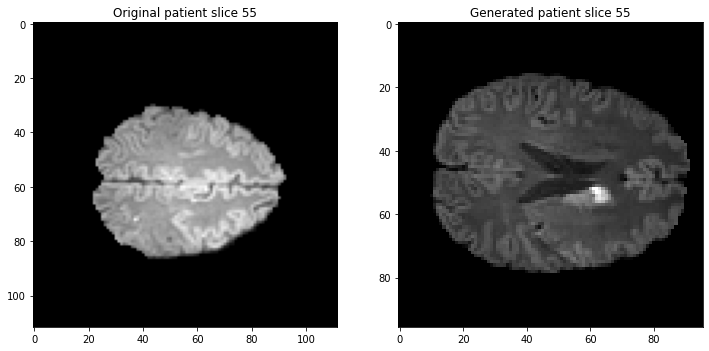

In [ ]:
import matplotlib.pyplot as plt
number_slice = 55
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")

torch.Size([1, 1, 112, 112, 73])


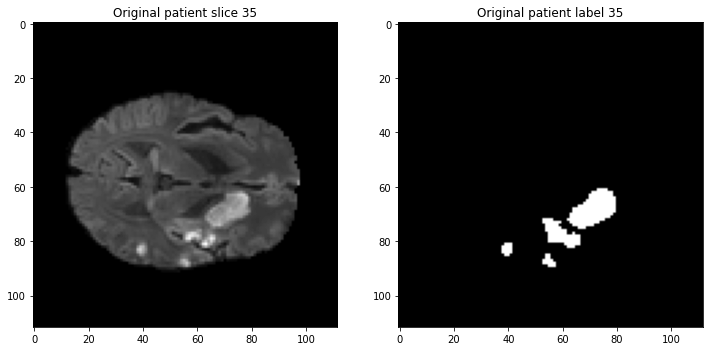

In [ ]:
import matplotlib.pyplot as plt
number_slice = 35
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Original patient label {number_slice}")
plt.imshow(original_patient["label"][0, 0, :, :, number_slice], cmap="gray")
print(original_patient["image"].shape)

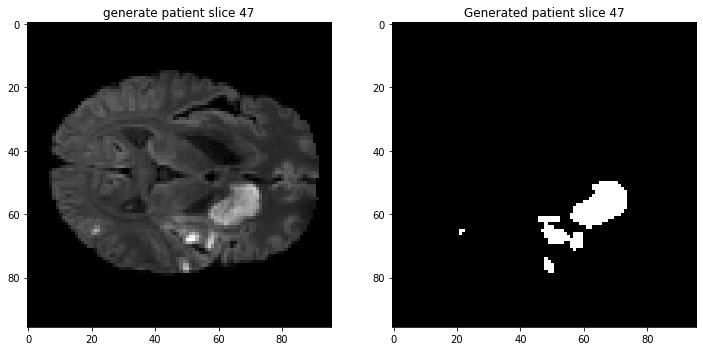

In [ ]:
import matplotlib.pyplot as plt
number_slice = 47
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"generate patient slice {number_slice}")
plt.imshow(generat_patient["image"][1, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["label"][1, 0, :, :, number_slice], cmap="gray")


In [ ]:
!pip install ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import argparse
import numpy as np
import random
import monai
import time
# from networks import build_net
import logging
import os
import sys
import tempfile
from glob import glob
#from ignite.metrics import Accuracy
import nibabel as nib
import torch
import argparse
from monai.data import CacheDataset, DataLoader, Dataset
import SimpleITK as sitk
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.data import NiftiSaver, create_test_image_3d, list_data_collate
from collections import OrderedDict
#from monai.handlers import (MeanDice, StatsHandler, ValidationHandler, CheckpointSaver, LrScheduleHandler, CheckpointLoader,
                        # SegmentationSaver, TensorBoardImageHandler, TensorBoardStatsHandler)
from monai.inferers import SimpleInferer, SlidingWindowInferer
from monai.utils import set_determinism
import re
from monai.data import create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.transforms import (Activationsd,MeanEnsembled, GaussianSmoothd, CropForegroundd, ThresholdIntensityd, Activations,AsDiscrete, LoadImaged, AsChannelFirstd, VoteEnsembled, AsDiscreted, Compose, AddChanneld, Transpose, ConcatItemsd,
                              ScaleIntensityd, Resized,ToTensord, RandSpatialCropd, Rand3DElasticd, RandAffined, RandGaussianSmoothd, SpatialPadd,
    Spacingd, Orientationd, RandShiftIntensityd, BorderPadd, RandGaussianNoised, RandAdjustContrastd,NormalizeIntensityd,RandFlipd, KeepLargestConnectedComponent)

#from monai.engines import (
   # EnsembleEvaluator,
   # SupervisedEvaluator,
   # SupervisedTrainer
#)

from skimage.measure import label
def getLargestCC(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(int)
    return labels_max


def Padding(image, reference):


    size_new = reference.GetSize()

    output_size = tuple(size_new)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(reference.GetSpacing())
    resampler.SetSize(output_size)

    # resample on label
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetOutputOrigin(reference.GetOrigin())
    resampler.SetOutputDirection(reference.GetDirection())

    image = resampler.Execute(image)

    return image


def resize(img, new_size, interpolator):
    # img = sitk.ReadImage(img)
    dimension = img.GetDimension()

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    reference_physical_size[:] = [(sz - 1) * spc if sz * spc > mx else mx for sz, spc, mx in
                                  zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

    # Create the reference image with a zero origin, identity direction cosine matrix and dimension
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()
    reference_size = new_size
    reference_spacing = [phys_sz / (sz - 1) for sz, phys_sz in zip(reference_size, reference_physical_size)]

    reference_image = sitk.Image(reference_size, img.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    # Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
    # this takes into account size, spacing and direction cosines. For the vast majority of images the direction
    # cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
    # spacing will not yield the correct coordinates resulting in a long debugging session.
    reference_center = np.array(
        reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize()) / 2.0))

    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))

    # centered_transform = sitk.Transform(transform)
    # centered_transform.AddTransform(centering_transform)

    centered_transform = sitk.CompositeTransform([transform, centering_transform])

    # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth
    # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that
    # no new labels are introduced.

    return sitk.Resample(img, reference_image, centered_transform, interpolator, 0.0)


def resample_sitk_image(sitk_image, spacing=None, interpolator=None, fill_value=0):
    # https://github.com/SimpleITK/SlicerSimpleFilters/blob/master/SimpleFilters/SimpleFilters.py
    _SITK_INTERPOLATOR_DICT = {
        'nearest': sitk.sitkNearestNeighbor,
        'linear': sitk.sitkLinear,
        'gaussian': sitk.sitkGaussian,
        'label_gaussian': sitk.sitkLabelGaussian,
        'bspline': sitk.sitkBSpline,
        'hamming_sinc': sitk.sitkHammingWindowedSinc,
        'cosine_windowed_sinc': sitk.sitkCosineWindowedSinc,
        'welch_windowed_sinc': sitk.sitkWelchWindowedSinc,
        'lanczos_windowed_sinc': sitk.sitkLanczosWindowedSinc
    }

    if isinstance(sitk_image, str):
        sitk_image = sitk.ReadImage(sitk_image)
    num_dim = sitk_image.GetDimension()

    if not interpolator:
        interpolator = 'linear'
        pixelid = sitk_image.GetPixelIDValue()

        if pixelid not in [1, 2, 4]:
            raise NotImplementedError(
                'Set `interpolator` manually, '
                'can only infer for 8-bit unsigned or 16, 32-bit signed integers')
        if pixelid == 1:  # 8-bit unsigned int
            interpolator = 'nearest'

    orig_pixelid = sitk_image.GetPixelIDValue()
    orig_origin = sitk_image.GetOrigin()
    orig_direction = sitk_image.GetDirection()
    orig_spacing = np.array(sitk_image.GetSpacing())
    orig_size = np.array(sitk_image.GetSize(), dtype=np.int)

    if not spacing:
        min_spacing = orig_spacing.min()
        new_spacing = [min_spacing] * num_dim
    else:
        new_spacing = [float(s) for s in spacing]

    assert interpolator in _SITK_INTERPOLATOR_DICT.keys(), \
        '`interpolator` should be one of {}'.format(_SITK_INTERPOLATOR_DICT.keys())

    sitk_interpolator = _SITK_INTERPOLATOR_DICT[interpolator]

    new_size = orig_size * (orig_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(np.int)  # Image dimensions are in integers
    new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays

    resample_filter = sitk.ResampleImageFilter()

    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetDefaultPixelValue(orig_pixelid)
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetDefaultPixelValue(fill_value)

    resampled_sitk_image = resample_filter.Execute(sitk_image)

    return resampled_sitk_image


def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def lstFiles(Path):

    images_list = []  # create an empty list, the raw image data files is stored here
    for dirName, subdirList, fileList in os.walk(Path):
        for filename in fileList:
            if ".nii.gz" in filename.lower():
                images_list.append(os.path.join(dirName, filename))
            elif ".nii" in filename.lower():
                images_list.append(os.path.join(dirName, filename))
            elif ".mhd" in filename.lower():
                images_list.append(os.path.join(dirName, filename))

    images_list = sorted(images_list, key=numericalSort)

    return images_list


def new_state_dict(file_name):
    state_dict = torch.load(file_name)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k[:6] == 'module':
            name = k[7:]
            new_state_dict[name] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


def new_state_dict_cpu(file_name):
    state_dict = torch.load(file_name, map_location='cpu')
    new_state_dict_cpu = OrderedDict()
    for k, v in state_dict.items():
        if k[:6] == 'module':
            name = k[7:]
            new_state_dict_cpu[name] = v
        else:
            new_state_dict_cpu[k] = v
    return new_state_dict_cpu


def from_numpy_to_itk(image_np, image_itk):

    # read image file
    reader = sitk.ImageFileReader()
    reader.SetFileName(image_itk)
    image_itk = reader.Execute()

    image_np = np.transpose(image_np, (2, 1, 0))
    image = sitk.GetImageFromArray(image_np)
    image.SetDirection(image_itk.GetDirection())
    image.SetSpacing(image_itk.GetSpacing())
    image.SetOrigin(image_itk.GetOrigin())
    return image


# function to keep track of the cropped area and coordinates
def statistics_crop(image, resolution):

    files = [{"image": image}]

    reader = sitk.ImageFileReader()
    reader.SetFileName(image)
    image_itk = reader.Execute()
    original_resolution = image_itk.GetSpacing()

    # original size
    transforms = Compose([
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        ToTensord(keys=['image'])])
    data = monai.data.Dataset(data=files, transform=transforms)
    loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
    loader = monai.utils.misc.first(loader)
    im, = (loader['image'][0])
    vol = im.numpy()
    original_shape = vol.shape

    # cropped foreground size
    transforms = Compose([
        LoadImaged(keys=['image']),
        AddChanneld(keys=['image']),
        CropForegroundd(keys=['image'], source_key='image', start_coord_key='foreground_start_coord',
                        end_coord_key='foreground_end_coord', ),  # crop CropForeground
        ToTensord(keys=['image', 'foreground_start_coord', 'foreground_end_coord'])])

    data = monai.data.Dataset(data=files, transform=transforms)
    loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
    loader = monai.utils.misc.first(loader)
    im, coord1, coord2 = (loader['image'][0], loader['foreground_start_coord'][0], loader['foreground_end_coord'][0])
    vol = im[0].numpy()
    coord1 = coord1.numpy()
    coord2 = coord2.numpy()
    crop_shape = vol.shape

    if resolution is not None:

        transforms = Compose([
            LoadImaged(keys=['image']),
            AddChanneld(keys=['image']),
            CropForegroundd(keys=['image'], source_key='image'),  # crop CropForeground
            Spacingd(keys=['image'], pixdim=resolution, mode=('bilinear')),  # resolution
            ToTensord(keys=['image'])])

        data = monai.data.Dataset(data=files, transform=transforms)
        loader = DataLoader(data, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
        loader = monai.utils.misc.first(loader)
        im, = (loader['image'][0])
        vol = im.numpy()
        resampled_size = vol.shape

    else:

        resampled_size = original_shape

    return original_shape, crop_shape, coord1, coord2, resampled_size, original_resolution


def build_net_CT(patch_size,resolution):

    from monai.networks.layers import Norm

    sizes, spacings = patch_size, resolution

    strides, kernels = [], []

    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)
    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])

    # # create Unet

    nn_Unet = monai.networks.nets.DynUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        kernel_size=kernels,
        strides=strides,
        upsample_kernel_size=strides[1:],
        res_block=True,
    )

    return nn_Unet


def crop_window(prostate_contour):
    # Cut data, restricted to the prostate contours + a pitch per direction per dimension.
    """
    nrrd has the following format, assuming to watch the patient from the front:
    (x, y, z)
    x: left to right (ascending)
    y: front to back (ascending)
    z: bottom to top (ascending)
    """
    pitch = 5
    pattern = np.where(prostate_contour == 1)

    minx = np.min(pattern[0]) - pitch
    maxx = np.max(pattern[0]) + pitch
    miny = np.min(pattern[1]) - pitch
    maxy = np.max(pattern[1]) + pitch
    minz = np.min(pattern[2]) - pitch
    maxz = np.max(pattern[2]) + pitch

    if (maxx - minx) % 2 != 0:
        maxx += 1
    if (maxy - miny) % 2 != 0:
        maxy += 1
    if (maxz - minz) % 2 != 0:
        maxz += 1

    """
    Choose all tensors to have size of 64x64x64
    """
    limit = 32

    while maxx - minx < limit:
        maxx += 1
        minx -= 1

    while maxy - miny < limit:
        maxy += 1
        miny -= 1

    while maxz - minz < limit:
        maxz += 1
        minz -= 1

    return minx, maxx, miny, maxy, minz, maxz


def uniform_img_dimensions(image, label, nearest):

    image_array = sitk.GetArrayFromImage(image)
    image_array = np.transpose(image_array, axes=(2, 1, 0))  # reshape array from itk z,y,x  to  x,y,z
    image_shape = image_array.shape

    if nearest is True:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='nearest')
        res = resize(label,image_shape,sitk.sitkNearestNeighbor)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('uint8'))
        # print(res.GetSize())

    else:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='linear')
        res = resize(label, image_shape, sitk.sitkLinear)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('float'))

    res.SetDirection(image.GetDirection())
    res.SetOrigin(image.GetOrigin())
    res.SetSpacing(image.GetSpacing())

    return image, res


def uniform_img_dimensions_internal(image, label, nearest):

    name_label = label

    image = sitk.ReadImage(image)
    label = sitk.ReadImage(label)
    image_array = sitk.GetArrayFromImage(image)
    image_array = np.transpose(image_array, axes=(2, 1, 0))  # reshape array from itk z,y,x  to  x,y,z
    image_shape = image_array.shape

    if nearest is True:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='nearest')
        res = resize(label,image_shape,sitk.sitkNearestNeighbor)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('uint8'))
        # print(res.GetSize())

    else:
        label = resample_sitk_image(label, spacing=image.GetSpacing(), interpolator='linear')
        res = resize(label, image_shape, sitk.sitkLinear)
        res = (np.rint(sitk.GetArrayFromImage(res)))
        res = sitk.GetImageFromArray(res.astype('float'))

    res.SetDirection(image.GetDirection())
    res.SetOrigin(image.GetOrigin())
    res.SetSpacing(image.GetSpacing())

    sitk.WriteImage(res, name_label)


In [ ]:
a='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/derivatives/sub-strokecase0002/ses-0001/sub-strokecase0002_ses-0001_msk.nii.gz'
b='/content/drive/MyDrive/ISLES2022/dataset-ISLES22^public^unzipped^version/rawdata/sub-strokecase0002/ses-0001/sub-strokecase0002_ses-0001_flair.nii.gz'
label = sitk.ReadImage(a)
image = sitk.ReadImage(b)

image = resample_sitk_image(image, spacing=(2.0, 2.0, 2.0), interpolator='linear', fill_value=0)
image, label = uniform_img_dimensions(image, label, nearest=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [ ]:
print(sitk.GetArrayFromImage(image).shape)
print(sitk.GetArrayFromImage(label).shape)

(125, 125, 100)
(125, 125, 100)


In [ ]:
imagenp=sitk.GetArrayFromImage(image).transpose(2,0,1)
labelnp=sitk.GetArrayFromImage(label).transpose(2,0,1)
print(imagenp.shape)
print(labelnp.shape)

(100, 125, 125)
(100, 125, 125)


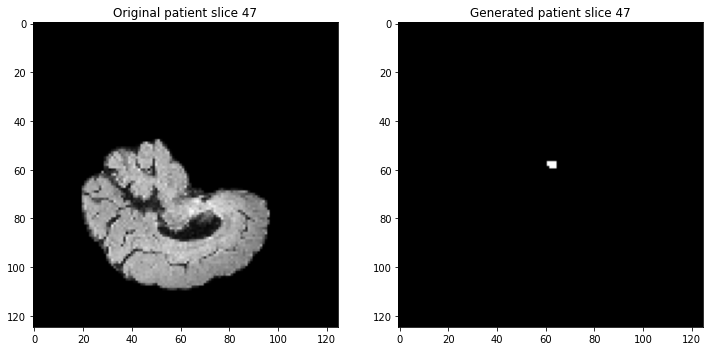

In [ ]:
import matplotlib.pyplot as plt
number_slice = 47
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(imagenp[number_slice,:, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(labelnp[number_slice,:, :], cmap="gray")